<a href="https://colab.research.google.com/github/Bharathi022002/flavours_of_cacao/blob/main/flavours_of_cacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f
from __future__ import print_function

import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

choc_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv", sep=",", encoding='latin-1')

choc_data.columns = ['maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent', 'maker_location', 'rating', 'bean_type', 'broad_origin']

choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Amsterdam', 'Holland')\
.str.replace('U.K.', 'England')\
.str.replace('Niacragua', 'Nicaragua')\
.str.replace('Domincan Republic', 'Dominican Republic')

choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"

choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

choc_data.head()

Instructions for updating:
non-resource variables are not supported in the long term


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


In [ ]:
choc_data.drop(columns=['review_date','reference_number'],inplace=True)
choc_data.head()

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,70.00,France,3.50,Blend,Peru


In [ ]:
class SimilarityModel(object):
  def __init__(self,
               dataframe,
               input_feature_names,
               output_feature_names,
               dense_feature_names,
               sparse_input_feature_embedding_dims,
               hidden_dims=[32],
               l2_regularization=0.0,
               use_bias=True,
               batch_size=100,
               inspect=False):
    used_feature_names = tuple(
        set(input_feature_names).union(output_feature_names))
    sparse_feature_names = tuple(
        set(used_feature_names).difference(dense_feature_names))
    sparse_feature_vocabs = {
        sfn: sorted(list(set(choc_data[sfn].values)))
        for sfn in sparse_feature_names
    }

    sparse_output_feature_names = (
        tuple(set(sparse_feature_names).intersection(output_feature_names)))
    keys_and_values = {}
    for fn in sparse_output_feature_names:
      keys = tf.constant(
          sparse_feature_vocabs[fn],
          dtype=tf.string,
          name='{}_vocab_keys'.format(fn))
      values = tf.range(
          len(sparse_feature_vocabs[fn]),
          dtype=tf.int64,
          name='{}_vocab_values'.format(fn))
      keys_and_values[fn] = (keys, values)
    self._session = None
    self._loss = None
    self._metrics = {}
    self._embeddings = None
    self._vars_to_inspect = {}

    def split_dataframe(df, holdout_fraction=0.1):
      test = df.sample(frac=holdout_fraction, replace=False)
      train = df[~df.index.isin(test.index)]
      return train, test

    train_dataframe, test_dataframe = split_dataframe(dataframe)

    def make_batch(dataframe, batch_size):
      used_features = {ufn: dataframe[ufn] for ufn in used_feature_names}
      batch = (
          tf.data.Dataset.from_tensor_slices(used_features).shuffle(1000)
          .repeat().batch(batch_size).make_one_shot_iterator().get_next())
      if inspect:
        for k, v in six.iteritems(batch):
          self._vars_to_inspect['input_%s' % k] = v
      return batch

    def generate_feature_columns(feature_names):
      used_sparse_feature_names = (
          tuple(set(sparse_feature_names).intersection(feature_names)))
      used_dense_feature_names = (
          tuple(set(dense_feature_names).intersection(feature_names)))
      f_columns = {}
      for sfn in used_sparse_feature_names:
        sf_column = tf.feature_column.categorical_column_with_vocabulary_list(
            key=sfn,
            vocabulary_list=sparse_feature_vocabs[sfn],
            num_oov_buckets=0)
        f_columns[sfn] = tf.feature_column.embedding_column(
            categorical_column=sf_column,
            dimension=sparse_input_feature_embedding_dims[sfn],
            combiner='mean',
            initializer=tf.truncated_normal_initializer(stddev=.1))
      for dfn in used_dense_feature_names:
        f_columns[dfn] = tf.feature_column.numeric_column(dfn)
      return f_columns

    def create_tower(features, columns):
      # TODO: sanity check the arguments.
      # Input features.
      input_columns = [columns[fn] for fn in input_feature_names]
      hidden_layer = tf.feature_column.input_layer(features, input_columns)
      dense_input_feature_names = (
          tuple(set(dense_feature_names).intersection(input_feature_names)))
      input_dim = (
          sum(sparse_input_feature_embedding_dims.values()) +
          len(dense_input_feature_names))
      for layer_idx, layer_output_dim in enumerate(hidden_dims):
        w = tf.get_variable(
            'hidden%d_w_' % layer_idx,
            shape=[input_dim, layer_output_dim],
            initializer=tf.truncated_normal_initializer(
                stddev=1.0 / np.sqrt(layer_output_dim)))
        if inspect:
          self._vars_to_inspect['hidden%d_w_' % layer_idx] = w
        hidden_layer = tf.matmul(hidden_layer, w)  # / 10.)
        if inspect:
          self._vars_to_inspect['hidden_layer_%d' % layer_idx] = hidden_layer
        input_dim = layer_output_dim
      # Output features.
      output_layer = {}
      for ofn in output_feature_names:
        if ofn in sparse_feature_names:
          feature_dim = len(sparse_feature_vocabs[ofn])
        else:
          feature_dim = 1
        w = tf.get_variable(
            'output_w_%s' % ofn,
            shape=[input_dim, feature_dim],
            initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                        np.sqrt(feature_dim)))
        if inspect:
          self._vars_to_inspect['output_w_%s' % ofn] = w
        if use_bias:
          bias = tf.get_variable(
              'output_bias_%s' % ofn,
              shape=[1, feature_dim],
              initializer=tf.truncated_normal_initializer(stddev=1.0 /
                                                          np.sqrt(feature_dim)))
          if inspect:
            self._vars_to_inspect['output_bias_%s' % ofn] = bias
        else:
          bias = tf.constant(0.0, shape=[1, feature_dim])
        output_layer[ofn] = {
            'labels':
                features[ofn],
            'logits':
                tf.add(tf.matmul(hidden_layer, w), bias)  # w / 10.), bias)
        }
        if inspect:
          self._vars_to_inspect['output_labels_%s' %
                                ofn] = output_layer[ofn]['labels']
          self._vars_to_inspect['output_logits_%s' %
                                ofn] = output_layer[ofn]['logits']
      return hidden_layer, output_layer

    def similarity_loss(top_embeddings, output_layer):
      losses = {}
      total_loss = tf.scalar_mul(l2_regularization,
                                 tf.nn.l2_loss(top_embeddings))
      for fn, output in six.iteritems(output_layer):
        if fn in sparse_feature_names:
          losses[fn] = tf.reduce_mean(
              tf.nn.sparse_softmax_cross_entropy_with_logits(
                  logits=output['logits'],
                  labels=tf.feature_to_id(
                      output['labels'], keys_and_values=keys_and_values[fn])))
        else:
          losses[fn] = tf.sqrt(
              tf.reduce_mean(
                  tf.square(output['logits'] -
                            tf.cast(output['labels'], tf.float32))))
        total_loss += losses[fn]
      return total_loss, losses

    # Body of the constructor.
    input_feature_columns = generate_feature_columns(input_feature_names)
    # Train
    with tf.variable_scope('model', reuse=False):
      train_hidden_layer, train_output_layer = create_tower(
          make_batch(train_dataframe, batch_size), input_feature_columns)
      self._train_loss, train_losses = similarity_loss(train_hidden_layer,
                                                       train_output_layer)
    # Test
    with tf.variable_scope('model', reuse=True):
      test_hidden_layer, test_output_layer = create_tower(
          make_batch(test_dataframe, batch_size), input_feature_columns)
      test_loss, test_losses = similarity_loss(test_hidden_layer,
                                               test_output_layer)
    # Whole dataframe to get final embeddings
    with tf.variable_scope('model', reuse=True):
      self._hidden_layer, _ = create_tower(
          make_batch(dataframe, dataframe.shape[0]), input_feature_columns)
    # Metrics is a dictionary of dictionaries of dictionaries.
    # The 3 levels are used as plots, line colors, and line styles respectively.
    self._metrics = {
        'total': {
            'train': {'loss': self._train_loss},
            'test': {'loss': test_loss}
        },
        'feature': {
            'train': {'%s loss' % k: v for k, v in six.iteritems(train_losses)},
            'test': {'%s loss' % k: v for k, v in six.iteritems(test_losses)}
        }
    }

  def train(self,
            num_iterations=30,
            learning_rate=1.0,
            plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    with self._train_loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._train_loss)
      opt_init_op = tf.variables_initializer(opt.variables())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.local_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      self._session.run(opt_init_op)
      if plot_results:  
        iterations = []
        metrics_vals = {k0: {k1: {k2: []
                                  for k2 in v1}
                             for k1, v1 in six.iteritems(v0)}
                        for k0, v0 in six.iteritems(self._metrics)}

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, self._metrics))

        # Printing the 1 liner with losses.
        if (i % 10 == 0) or i == num_iterations:
          print('\riteration%6d,   ' % i + ',   '.join(
              ['%s %s %s: %7.3f' % (k0, k1, k2, v2)
               for k0, v0 in six.iteritems(results)
               for k1, v1 in six.iteritems(v0)
               for k2, v2 in six.iteritems(v1)])
                , end=" "
               )
          if plot_results:
            iterations.append(i)
            for k0, v0 in six.iteritems(results):
              for k1, v1 in six.iteritems(v0):
                for k2, v2 in six.iteritems(v1):
                  metrics_vals[k0][k1][k2].append(results[k0][k1][k2])

      # Feedforward the entire dataframe to get all the embeddings.
      self._embeddings = self._session.run(self._hidden_layer)

      # Plot the losses and embeddings.
      if plot_results:
        num_subplots = len(metrics_vals) + 1
        colors = 10 * ('red', 'blue', 'black', 'green')
        styles = 10 * ('-', '--', '-.', ':')
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i0, (k0, v0) in enumerate(six.iteritems(metrics_vals)):
          ax = fig.add_subplot(1, num_subplots, i0+1)
          ax.set_title(k0)
          for i1, (k1, v1) in enumerate(six.iteritems(v0)):
            for i2, (k2, v2) in enumerate(six.iteritems(v1)):
              ax.plot(iterations, v2, label='%s %s' % (k1, k2),
                      color=colors[i1], linestyle=styles[i2])
          ax.set_xlim([1, num_iterations])
          ax.set_yscale('log')
          ax.legend()
        ax.legend(loc='upper right')
        ax = fig.add_subplot(1, num_subplots, num_subplots)
        ax.scatter(
            self._embeddings[:, 0], self._embeddings[:, 1],
            alpha=0.5, marker='o')
        ax.set_title('embeddings')


  @property
  def embeddings(self):
    return self._embeddings

------ build model
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn AP

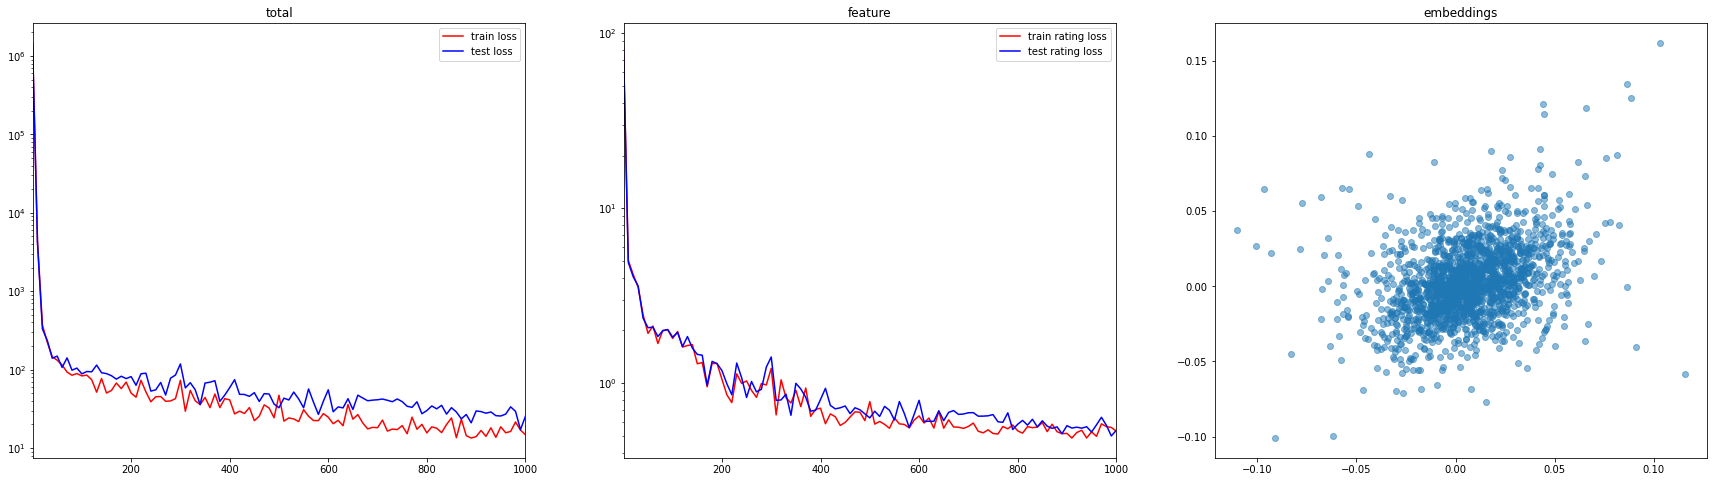

In [ ]:
sparse_feature_names = ('maker', 'maker_location', 'broad_origin',
                        'specific_origin', 'bean_type')
dense_feature_names = ('reference_number', 'review_date', 'cocoa_percent',
                       'rating')
input_feature_names = ('maker', 'maker_location', 'broad_origin',
                       'cocoa_percent', 'bean_type','rating', )
output_feature_names = ['rating']
default_embedding_dims = {
    sfn: int(round(math.log(choc_data[sfn].nunique()) / math.log(2)))
    for sfn in set(sparse_feature_names).intersection(input_feature_names)
}
sparse_input_feature_embedding_dims = default_embedding_dims  
l2_regularization = 10  
hidden_dims = [20, 10]  

print('------ build model')
with tf.Graph().as_default():
  similarity_model = SimilarityModel(
      choc_data,
      input_feature_names=input_feature_names,
      output_feature_names=output_feature_names,
      dense_feature_names=dense_feature_names,
      sparse_input_feature_embedding_dims=sparse_input_feature_embedding_dims,
      hidden_dims=hidden_dims,
      l2_regularization=l2_regularization,
      batch_size=100,
      use_bias=True,
      inspect=True)

print('------ train model')
similarity_model.train(
    num_iterations=1000,
    learning_rate=0.1,
    optimizer=tf.train.AdagradOptimizer)
print('\n')


In [ ]:
def dfSimilarity(df,centroids):
  numPoints = len(df.index)
  numCentroids = len(centroids.index)
  pointNorms = np.square(nla.norm(df,axis=1))
  pointNorms = np.reshape(pointNorms,[numPoints,1])
  centroidNorms = np.square(nla.norm(centroids,axis=1))
  centroidNorms = np.reshape(centroidNorms,(1,numCentroids))
  similarities = pointNorms + centroidNorms - 2.0*np.dot(df,np.transpose(centroids))
  similarities = similarities/10.0
  similarities = similarities.clip(min=0.0)
  similarities = np.sqrt(similarities)
  return similarities

def initCentroids(df,k,feature_cols):
  limit = len(df.index)
  centroids_key = np.random.randint(0,limit-1,k)
  centroids = df.loc[centroids_key,feature_cols].copy(deep=True)
  centroids.reset_index(drop=True,inplace=True)
  return centroids

def pt2centroid(df,centroids,feature_cols):
  numCentroids = len(centroids.index)
  numExamples = len(df.index)
  dist = dfSimilarity(df.loc[:,feature_cols],centroids.loc[:,feature_cols])
  df.loc[:,'centroid'] = np.argmin(dist,axis=1) 
  df.loc[:,'pt2centroid'] = np.min(dist,axis=1) 
  return df

def recomputeCentroids(df,centroids,feature_cols):
  numCentroids = len(centroids.index)
  for cen in range(numCentroids):
    dfSubset = df.loc[df['centroid'] == cen, feature_cols] 
    if not(dfSubset.empty):
      clusterAvg = np.sum(dfSubset)/len(dfSubset.index)
      centroids.loc[cen] = clusterAvg
  return centroids

def kmeans(df,k,feature_cols,verbose):
  flagConvergence = False
  maxIter = 100
  iter = 0                  
  centroids = initCentroids(df,k,feature_cols)
  while not(flagConvergence):
    iter += 1
    oldMapping = df['centroid'].copy(deep=True)
    df = pt2centroid(df,centroids,feature_cols)
    centroids = recomputeCentroids(df,centroids,feature_cols)
    newMapping = df['centroid']
    flagConvergence = all(oldMapping == newMapping)
    if verbose == 1:
      print("Total distance:" + str(np.sum(df['pt2centroid'])))
    if (iter > maxIter):
      print('k-means did not converge! Reached maximum iteration limit of ' \
            + str(maxIter) + '.')
      sys.exit()
      return
  print('k-means converged for ' + str(k) + ' clusters' + \
        ' after ' + str(iter) + ' iterations!')
  return [df,centroids]

In [ ]:
k = 160 #@param

# Extract embeddings into a dataframe
choc_embed = similarity_model.embeddings
choc_embed = pd.DataFrame(choc_embed)

feature_cols = choc_embed.columns.values # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_embed['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_embed['pt2centroid'] = 2
[choc_embed,centroids] = kmeans(choc_embed,k,feature_cols,1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:")
choc_embed.head()

Total distance:22.975903
Total distance:20.740028
Total distance:20.122787
Total distance:19.867668
Total distance:19.644913
Total distance:19.533192
Total distance:19.491413
Total distance:19.464209
Total distance:19.439018
Total distance:19.422733
Total distance:19.40609
Total distance:19.401016
Total distance:19.398956
Total distance:19.397957
Total distance:19.397966
Total distance:19.39767
k-means converged for 160 clusters after 16 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,0,1,2,3,4,5,6,7,8,9,centroid,pt2centroid
0,0.00,0.01,-0.01,0.05,-0.00,0.07,0.01,0.01,-0.05,-0.01,59,0.01
1,0.03,-0.00,0.01,-0.01,-0.01,-0.00,0.01,-0.01,-0.01,0.02,122,0.01
2,-0.00,0.01,-0.01,-0.03,0.01,-0.01,-0.00,0.00,0.04,0.00,154,0.01
3,0.05,0.03,-0.05,0.15,-0.02,0.09,0.02,-0.01,-0.14,-0.01,105,0.01
4,-0.02,-0.02,0.00,-0.03,0.00,-0.03,0.01,-0.01,0.02,0.01,34,0.01


In [ ]:
clusterNumber = 20 #@param
choc_data.loc[choc_embed['centroid']==clusterNumber,:]

,maker,specific_origin,cocoa_percent,maker_location,rating,bean_type,broad_origin
5,A. Morin,Carenero,70.00,France,2.75,Criollo,Venezuela
85,Amedei,Toscano Black,63.00,Italy,3.50,Blend,Toscano Black
333,C-Amaro,Trinidad,70.00,Italy,2.50,Trinitario,Trinidad
460,Coppeneur,Chuao 100hr,70.00,Germany,3.50,"Criollo, Trinitario",Venezuela
493,Dandelion,Colombian,70.00,U.S.A.,3.25,Blend,Colombia
569,Domori,Madagascar,70.00,Italy,3.50,Trinitario,Madagascar
579,Dormouse,"Colombia,Batch 9",80.00,England,2.75,"Criollo, Trinitario",Colombia
588,Duffy's,"Nicaliso,Xoco",71.00,England,3.25,Criollo,Nicaragua
628,Escazu,Carenero Superior,81.00,U.S.A.,3.50,Criollo,Venezuela
768,Guittard,"Los Rios,Quevedo",65.00,U.S.A.,3.50,Forastero (Arriba),Ecuador


In [ ]:
#@title Run cell to setup functions { display-mode: "form" }
def clusterCardinality(df):
  k = np.max(df["centroid"]) + 1
  if six.PY2:
    k = k.astype(int)
  print("Number of clusters:"+str(k))
  clCard = np.zeros(k)
  for kk in range(k):
    clCard[kk] = np.sum(df["centroid"]==kk)
  if six.PY2:
    clCard = clCard.astype(int)
  # print "Cluster Cardinality:"+str(clCard)
  plt.figure()
  plt.bar(range(k),clCard)
  plt.title('Cluster Cardinality')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Points in Cluster')
  return clCard

def clusterMagnitude(df):
  k = np.max(df["centroid"]) + 1
  if six.PY2:
    k = k.astype(int)
  cl = np.zeros(k)
  clMag = np.zeros(k)
  for kk in range(k):
    idx = np.where(df["centroid"]==kk)
    idx = idx[0]
    clMag[kk] = np.sum(df.loc[idx,"pt2centroid"])
  # print "Cluster Magnitude:",clMag #precision set using np pref
  plt.figure()
  plt.bar(range(k),clMag)
  plt.title('Cluster Magnitude')
  plt.xlabel('Cluster Number: '+str(0)+' to '+str(k-1))
  plt.ylabel('Total Point-to-Centroid Distance')
  return clMag

def plotCardVsMag(clCard,clMag):
  plt.figure()
  plt.scatter(clCard,clMag)
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.title('Magnitude vs Cardinality')
  plt.ylabel('Magnitude')
  plt.xlabel('Cardinality')

def clusterQualityMetrics(df):
  clCard = clusterCardinality(df)
  clMag = clusterMagnitude(df)
  plotCardVsMag(clCard,clMag)

k-means converged for 5 clusters after 24 iterations!
k-means converged for 15 clusters after 81 iterations!
k-means converged for 25 clusters after 27 iterations!
k-means converged for 35 clusters after 34 iterations!
k-means converged for 45 clusters after 31 iterations!


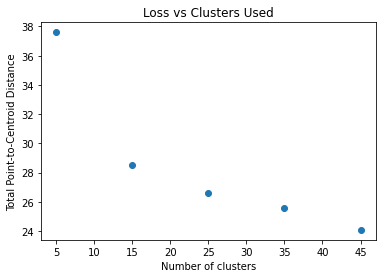

In [ ]:
def lossVsClusters(kmin, kmax, kstep, choc_data):
  kmax += 1  # include kmax-th cluster in range
  kRange = range(kmin, kmax, kstep)
  loss = np.zeros(len(kRange))
  lossCtr = 0
  for kk in kRange:
    [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
    loss[lossCtr] = np.sum(choc_data['pt2centroid'])
    lossCtr += 1
  plt.scatter(kRange, loss)
  plt.title('Loss vs Clusters Used')
  plt.xlabel('Number of clusters')
  plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 50  # @param
kstep = 10  # @param
lossVsClusters(kmin, kmax, kstep, choc_embed)